# 1. Importing Libraries

In [80]:
import pandas as pd 
import numpy as np 
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split 
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from BorutaShap import BorutaShap
from imblearn.combine import SMOTEENN
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, log_loss, cohen_kappa_score, plot_confusion_matrix

# 2. Reading Data

In [81]:
#this function is to read, transform and join 2 data frame

def read_features():
    path = 'secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature_'+str(x+1) for x in range(len(df.columns))]
    return df



def read_target():
    path = 'secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#for the testing purporse, trim to remain first 100 rows only
X = read_features()
y = read_target().iloc[:,0]

In [82]:
#Row & Columns of Features 
X.shape

(1567, 590)

# 3. Splitting Training & Testing Data

In [83]:
#Splitting the Data: 80% Training, 20% Testing Data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1,stratify=y)

In [84]:
#Rows and Columns of X_Train DF
x_train.shape

(1253, 590)

In [85]:
#Rows and Columns of X_Train DF
x_test.shape

(314, 590)

# 4. Reducing Dimensionality

## 4.1. Remove duplicated Columns

In [86]:
#Function for finding and removing duplicated columns (features)
def remove_duplicated_columns(df):
    dict_duplicate_pair = {}
    dict_duplicate_matches = {}
    list_duplicate = []
    to_remove = []
    for i in range(0, len(df.columns)):
        l = []
        for j in range(i+1,len(df.columns)):
            dict_duplicate_pair[str(i+1)+';'+str(j+1)] = df.iloc[:,i].equals(df.iloc[:,j])
            if df.iloc[:,i].equals(df.iloc[:,j]) == True:
                if j not in list_duplicate:
                    l.append(j)
                    to_remove.append('feature_'+str(j+1))
                list_duplicate.append(i)
                list_duplicate.append(j)
        if len(l)!=0:
            dict_duplicate_matches[i] = l


    df_duplicate_pair = pd.DataFrame.from_dict(dict_duplicate_pair, orient='index')
    df_duplicate_pair.columns=['duplicate']

    df_duplicate_matches = pd.DataFrame.from_dict(dict_duplicate_matches, orient='index')

    
    df = df.drop(columns=to_remove, axis = 1)

    return df

In [87]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_duplicated_columns(x_train)
x_train.shape

(1253, 486)

## 4.2. Removing Features with Constant Volatility

In [88]:
#Defining function to find and remove features with zero standard deviation 
def remove_constant_volatility(df):
    df_EDA= df.describe().T
    df_EDA= df_EDA[df_EDA["std"] == 0]
    df = df.drop(axis=1, columns=df_EDA.index)
    return df

In [89]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_constant_volatility(x_train)
x_train.shape

(1253, 474)

## 4.3. Remove Features with high % of Missing Values

In [90]:
#Defining function to remove features with a given % of missing values 
def remove_cols_with_high_pct_null(df, null_threshold):
    list_column_with_pct_null = pd.concat([df.isnull().sum(), df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    list_column_with_pct_null= list_column_with_pct_null[list_column_with_pct_null["Percentage (%)"] >= null_threshold]
    df = df.drop(axis=1, columns=list_column_with_pct_null.index)
    return df

In [91]:
#Using Function on x_train & printing new shape of dataframe after transformation 
x_train = remove_cols_with_high_pct_null(x_train, 0.7)
x_train.shape

(1253, 466)

# 5. Outlier & Missing Value Treatment

#Definition of Functiom
def outlier_clamp(df):
    for col in df.columns:
        ll_col = df[col].mean() - 2 * df[col].std()
        ul_col = df[col].mean() + 2 * df[col].std()
        df[col] = np.where(df[col]>ul_col,ul_col,np.where(df[col]<ll_col,ll_col,df[col]))
    return df

x_train = outlier_clamp(x_train)

#KNN only distance
def knndistance(df):
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation 
    knn = KNNImputer(n_neighbors=5, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

x_train = knndistance(x_train)

In [92]:
#Function to drop Outliers and impute Missing Values with KNN 
def outlierknn(df):
    #Outlier treatment first:
    for col in df.columns:
          ll_col = df[col].mean() - 3 * df[col].std()
          ul_col = df[col].mean() + 3 * df[col].std()
          df[col] = np.where(df[col]>ul_col,np.NaN,np.where(df[col]<ll_col,np.NaN,df[col]))
    #Scaling data 
    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns= df.columns)
    #KNN Imputation
    knn = KNNImputer(n_neighbors=3, weights='distance')
    df = pd.DataFrame(knn.fit_transform(df), columns=df.columns)
    #Reverse Scaling
    df = pd.DataFrame(scaler.inverse_transform(df), columns= df.columns)
    return df  

In [93]:
#Using function above on x_train
x_train = outlierknn(x_train)

# 6. Feature Selection

In [94]:
#This is BorutaShap with TENTATIVE features

#list_method=['shap','gini']

def BorutaShap_FS (X, y,method_option) :
    #modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, class_weight='balanced_subsample', max_depth=5, random_state=100)
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)

    # define model for resp. classifier
    modelshap.fit(X,y)
    feature_names = np.array(X.columns)
    # define Boruta Sahp feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure=method_option,
                              classification=True)  # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = False,random_state=100)  
    #feature_selector.plot(which_features='accepted',figsize=(20,10))
    tentative=X.loc[:,feature_selector.tentative]
    selected=feature_selector.Subset()
    selten=pd.concat([selected,tentative],axis=1)
    # call transform() on X to filter it down to selected features
    return  selten

In [95]:
x_train = BorutaShap_FS(x_train,y_train,'shap')

  0%|          | 0/100 [00:00<?, ?it/s]

In [96]:
#Shape of x_train after Feature Selection
x_train.shape

(1253, 14)

In [97]:
#Correlation Matrix of Remaining Features
x_train.corr()

,feature_478,feature_563,feature_66,feature_60,feature_148,feature_342,feature_442,feature_133,feature_349,feature_332,feature_206,feature_124,feature_476,feature_421
feature_478,1.000000,-0.041205,0.011083,0.213053,0.127089,0.965772,0.096947,0.094808,0.075932,-0.089345,0.997951,-0.000621,0.032221,0.127903
feature_563,-0.041205,1.000000,0.025285,-0.046322,0.418489,-0.025426,-0.091399,-0.191751,-0.010384,-0.039400,-0.041226,-0.061407,0.004402,0.414228
feature_66,0.011083,0.025285,1.000000,-0.383259,0.035018,0.024322,0.003846,0.017097,0.045223,-0.133756,0.015588,-0.073897,-0.122914,0.033659
feature_60,0.213053,-0.046322,-0.383259,1.000000,0.261027,0.196633,0.115434,0.166408,0.264768,-0.017971,0.208036,0.048769,-0.087381,0.262105
feature_148,0.127089,0.418489,0.035018,0.261027,1.000000,0.128258,0.025428,0.005778,0.154777,-0.025712,0.125027,-0.012749,-0.008549,0.999892
feature_342,0.965772,-0.025426,0.024322,0.196633,0.128258,1.000000,0.092578,0.103668,0.068675,-0.108981,0.967712,-0.015985,0.034910,0.128844
feature_442,0.096947,-0.091399,0.003846,0.115434,0.025428,0.092578,1.000000,0.153265,0.017402,0.072837,0.096962,0.020738,0.057268,0.027117
feature_133,0.094808,-0.191751,0.017097,0.166408,0.005778,0.103668,0.153265,1.000000,0.042493,0.016080,0.096177,-0.199839,-0.022785,0.007923
feature_349,0.075932,-0.010384,0.045223,0.264768,0.154777,0.068675,0.017402,0.042493,1.000000,-0.054543,0.073301,0.017463,-0.098570,0.155061
feature_332,-0.089345,-0.039400,-0.133756,-0.017971,-0.025712,-0.108981,0.072837,0.016080,-0.054543,1.000000,-0.086303,0.110986,0.598172,-0.024060


Text(0.5, 1.0, 'Correlation of remaining Features')

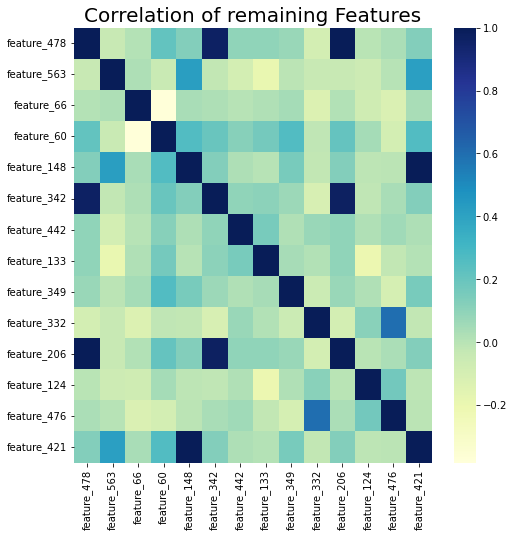

In [98]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

# 7. Multicolinearity Treatment

In [99]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):


    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                #Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [100]:
x_train=remove_collinear_features(x_train, 0.7)
x_train.shape

(1253, 11)

Text(0.5, 1.0, 'Correlation of remaining Features')

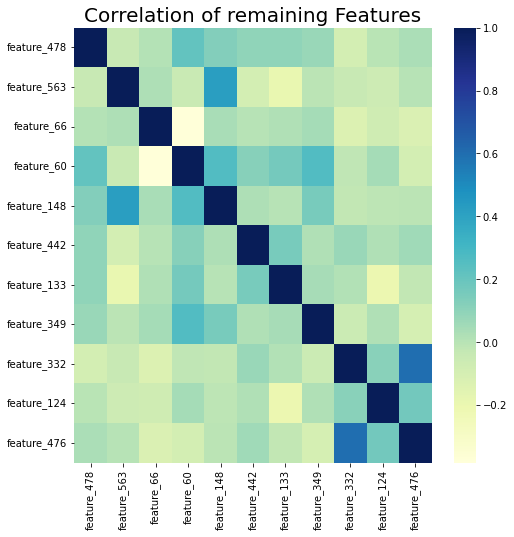

In [101]:
#Heatmap of Correlation of Remaining Feaures 
plt.rcParams['figure.figsize'] = (8, 8) #this is to set the size for the plot, making it bigger
sns.heatmap(x_train.corr(), cmap = "YlGnBu")
plt.title('Correlation of remaining Features', fontsize = 20)

# 8. Balancing

In [102]:
#Function SMOTEENN
def sampling(X_train, y_train):
    sampler = SMOTEENN(random_state=100)
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

# X_train, y_train = sampling(X_train, y_train,'SMOTE')
# X_train.shape

In [103]:
x_train, y_train = sampling(x_train, y_train)

In [104]:
x_train.shape

(1748, 11)

In [105]:
y_train.shape

(1748,)

# 9. Modeling

In [106]:
model = LogisticRegression(random_state=1)
model.fit(x_train, y_train)
# make predictions
expected = y_train
predicted = model.predict(x_train)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))


              precision    recall  f1-score   support

          -1       0.66      0.73      0.69       725
           1       0.79      0.73      0.76      1023

    accuracy                           0.73      1748
   macro avg       0.72      0.73      0.72      1748
weighted avg       0.74      0.73      0.73      1748

[[526 199]
 [274 749]]


In [107]:
cf_matrix = confusion_matrix(expected, predicted)
sensitivity = cf_matrix[1][1] / ( cf_matrix[1][1] + cf_matrix[1][0] )
sensitivity

0.7321603128054741

# 10. Test Data

In [108]:
#1. Remove Duplicated Columns 
x_test = remove_duplicated_columns(x_test)
x_test.shape

(314, 480)

In [109]:
#2. Remove Constant Volalitily
x_test = remove_constant_volatility(x_test)
x_test.shape

(314, 468)

In [110]:
#3. Remove High % of NA
x_test = remove_cols_with_high_pct_null(x_test, 0.6)
x_test.shape

(314, 444)

In [111]:
#4. Drop Outliers and KNN Imputation
x_test= outlierknn(x_test)

In [112]:
#5. Take the same Columns as in train data 
columns_list = x_train.columns
x_test = x_test.loc[:,columns_list]
x_test.shape

(314, 11)

In [113]:
exp_test = y_test
pred_test = model.predict(x_test)
# summarize the fit of the gnb
print(metrics.classification_report(exp_test, pred_test))
print(metrics.confusion_matrix(exp_test, pred_test))

              precision    recall  f1-score   support

          -1       0.96      0.70      0.81       293
           1       0.13      0.62      0.21        21

    accuracy                           0.70       314
   macro avg       0.55      0.66      0.51       314
weighted avg       0.91      0.70      0.77       314

[[206  87]
 [  8  13]]


In [114]:
cf_matrix_test = confusion_matrix(exp_test, pred_test)
sensitivity_test = cf_matrix_test[1][1] / ( cf_matrix_test[1][1] + cf_matrix_test[1][0] )
sensitivity_test

0.6190476190476191

In [115]:
#Accuracy
accuracy_score(exp_test, pred_test)

0.697452229299363

In [116]:
recall_score(exp_test, pred_test)

0.6190476190476191